# Import nltk

In [1]:
import nltk
%matplotlib inline

# Filtering out stopwords, names, and numbers


## Load English stopwords and print some of the words

In [2]:
sw = set(nltk.corpus.stopwords.words('english'))
print("Stop words:", list(sw)[:7])

Stop words: ['their', 'by', 'at', 'here', 'on', 'that', 'with']


## Load Gutenberg corpopra and print some of the filenames

In [3]:
gb = nltk.corpus.gutenberg
print("Gutenberg files:\n", gb.fileids()[-5:])

Gutenberg files:
 ['milton-paradise.txt', 'shakespeare-caesar.txt', 'shakespeare-hamlet.txt', 'shakespeare-macbeth.txt', 'whitman-leaves.txt']


## Extract sentences from milton-paradise.txt file

In [4]:
text_sent = gb.sents("milton-paradise.txt")[:2]
print("Unfiltered:", text_sent)

Unfiltered: [['[', 'Paradise', 'Lost', 'by', 'John', 'Milton', '1667', ']'], ['Book', 'I']]


## Filter out the stopwords from extracted sentences

In [5]:
for sent in text_sent:
    filtered = [w for w in sent if w.lower() not in sw]
    print("Filtered:\n", filtered)
    tagged = nltk.pos_tag(filtered)
    print("Tagged:\n", tagged)

    words= []
    for word in tagged:
        if word[1] != 'NNP' and word[1] != 'CD':
           words.append(word[0]) 

    print("Words:\n",words)

Filtered:
 ['[', 'Paradise', 'Lost', 'John', 'Milton', '1667', ']']
Tagged:
 [('[', 'JJ'), ('Paradise', 'NNP'), ('Lost', 'NNP'), ('John', 'NNP'), ('Milton', 'NNP'), ('1667', 'CD'), (']', 'NN')]
Words:
 ['[', ']']
Filtered:
 ['Book']
Tagged:
 [('Book', 'NN')]
Words:
 ['Book']


# Bag of words model

## Import scikit-learn

In [6]:
import sklearn as sk

## Load two documents from NLTK Gutenberg corpus

In [7]:
hamlet = gb.raw("shakespeare-hamlet.txt")
macbeth = gb.raw("shakespeare-macbeth.txt")

## Create the feature vector by omitting English stopwords

In [8]:
cv = sk.feature_extraction.text.CountVectorizer(stop_words='english')
print("Feature vector:\n", cv.fit_transform([hamlet, macbeth]).toarray())

Feature vector:
 [[ 1  0  1 ..., 14  0  1]
 [ 0  1  0 ...,  1  1  0]]


## Print a small selection of the features found

In [9]:
print("Features:\n", cv.get_feature_names()[:5])

Features:
 ['1599', '1603', 'abhominably', 'abhorred', 'abide']


# Analyzing word frequencies

In [10]:
import nltk
import string


gb = nltk.corpus.gutenberg
words = gb.words("shakespeare-caesar.txt")

sw = set(nltk.corpus.stopwords.words('english'))
punctuation = set(string.punctuation)
filtered = [w.lower() for w in words if w.lower() not in sw and w.lower() not in punctuation]
fd = nltk.FreqDist(filtered)
print("Words", list(fd.keys())[:5])
print("Counts", list(fd.values())[:5])
print("Max", fd.max())
print("Count", fd['d'])

fd = nltk.FreqDist(nltk.bigrams(filtered))
print("Bigrams", list(fd.keys())[:5])
print("Counts", list(fd.values())[:5])
print("Bigram Max", fd.max())
print("Bigram count", fd[('let', 'vs')])

Words ['tragedie', 'julius', 'caesar', 'william', 'shakespeare']
Counts [2, 1, 190, 1, 1]
Max caesar
Count 0
Bigrams [('tragedie', 'julius'), ('julius', 'caesar'), ('caesar', 'william'), ('william', 'shakespeare'), ('shakespeare', '1599')]
Counts [1, 1, 1, 1, 1]
Bigram Max ('let', 'vs')
Bigram count 16


# Naive Bayesian

In [11]:
import nltk
import string
import random

sw = set(nltk.corpus.stopwords.words('english'))
punctuation = set(string.punctuation)

def word_features(word):
   return {'len': len(word)}

def isStopword(word):
    return word in sw or word in punctuation
gb = nltk.corpus.gutenberg
words = gb.words("shakespeare-caesar.txt")

labeled_words = ([(word.lower(), isStopword(word.lower())) for 
word in words])
random.seed(42)
random.shuffle(labeled_words)
print(labeled_words[:5])

featuresets = [(word_features(n), word) for (n, word) in 
labeled_words]
cutoff = int(.9 * len(featuresets))
train_set, test_set = featuresets[:cutoff], featuresets[cutoff:]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print("'behold' class", classifier.classify(word_features('behold')))
print("'the' class", classifier.classify(word_features('the')))

print("Accuracy", nltk.classify.accuracy(classifier, test_set))
print(classifier.show_most_informative_features(5))

[('i', True), ('is', True), ('in', True), ('he', True), ('ambitious', False)]
'behold' class False
'the' class True
Accuracy 0.8521671826625387
Most Informative Features
                     len = 7               False : True   =     77.8 : 1.0
                     len = 6               False : True   =     52.2 : 1.0
                     len = 1                True : False  =     51.8 : 1.0
                     len = 2                True : False  =     10.9 : 1.0
                     len = 5               False : True   =     10.9 : 1.0
None


# Sentiment Analysis

In [12]:
import random
from nltk.corpus import movie_reviews
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk import NaiveBayesClassifier
from nltk.classify import accuracy
import string

labeled_docs = [(list(movie_reviews.words(fid)), cat)
        for cat in movie_reviews.categories()
        for fid in movie_reviews.fileids(cat)]
random.seed(42)
random.shuffle(labeled_docs)

review_words = movie_reviews.words()
print("# Review Words", len(review_words))

sw = set(stopwords.words('english'))
punctuation = set(string.punctuation)

def isStopWord(word):
    return word in sw or word in punctuation

filtered = [w.lower() for w in review_words if not isStopWord(w.lower())]
print("# After filter", len(filtered))
words = FreqDist(filtered)
N = int(.05 * len(words.keys()))
word_features = list(words.keys())[:N]

def doc_features(doc):
    doc_words = FreqDist(w for w in doc if not isStopWord(w))
    features = {}
    for word in word_features:
        features['count (%s)' % word] = (doc_words.get(word, 0))
    return features

featuresets = [(doc_features(d), c) for (d,c) in labeled_docs]
train_set, test_set = featuresets[200:], featuresets[:200]
classifier = NaiveBayesClassifier.train(train_set)
print("Accuracy", accuracy(classifier, test_set))

print(classifier.show_most_informative_features())

# Review Words 1583820
# After filter 710579
Accuracy 0.765
Most Informative Features
      count (apparently) = 2                 neg : pos    =     12.0 : 1.0
          count (stupid) = 2                 neg : pos    =     11.1 : 1.0
          count (boring) = 2                 neg : pos    =     10.7 : 1.0
             count (bad) = 5                 neg : pos    =     10.0 : 1.0
            count (best) = 4                 pos : neg    =      9.9 : 1.0
          count (anyway) = 2                 neg : pos    =      8.1 : 1.0
          count (wilson) = 1                 neg : pos    =      8.0 : 1.0
             count (bad) = 6                 neg : pos    =      7.4 : 1.0
   count (unimaginative) = 1                 neg : pos    =      7.4 : 1.0
       count (animation) = 3                 pos : neg    =      7.2 : 1.0
None


# Creating Word Clouds

In [13]:
from nltk.corpus import movie_reviews
from nltk.corpus import stopwords
from nltk import FreqDist
import string

sw = set(stopwords.words('english'))
punctuation = set(string.punctuation)

def isStopWord(word):
    return word in sw or word in punctuation
review_words = movie_reviews.words()
filtered = [w.lower() for w in review_words if not isStopWord(w.lower())]

words = FreqDist(filtered)
N = int(.01 * len(words.keys()))
tags = list(words.keys())[:N]

for tag in tags:
    print(tag, ':', words[tag])

plot : 1513
two : 1911
teen : 151
couples : 27
go : 1113
church : 69
party : 183
drink : 32
drive : 105
get : 1949
accident : 104
one : 5852
guys : 268
dies : 104
girlfriend : 218
continues : 88
see : 1749
life : 1586
nightmares : 26
deal : 219
watch : 603
movie : 5771
sorta : 10
find : 782
critique : 61
mind : 451
fuck : 17
generation : 96
touches : 55
cool : 208
idea : 386
presents : 78
bad : 1395
package : 30
makes : 992
review : 295
even : 2565
harder : 33
write : 119
since : 768
generally : 103
applaud : 10
films : 1536
attempt : 263
break : 175
mold : 14
mess : 159
head : 387
lost : 409
highway : 28
memento : 10
good : 2411
ways : 189
making : 602
types : 48
folks : 74
snag : 2
correctly : 17
seem : 574
taken : 225
pretty : 528
neat : 32
concept : 114
executed : 46
terribly : 58
problems : 293
well : 1906
main : 399
problem : 396
simply : 428
jumbled : 12
starts : 316
normal : 111
downshifts : 2
fantasy : 97
world : 1037
audience : 914
member : 126
going : 888
dreams : 131
charac

In [14]:
from nltk.corpus import movie_reviews
from nltk.corpus import stopwords
from nltk.corpus import names
from nltk import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
import itertools
import pandas as pd
import numpy as np
import string

sw = set(stopwords.words('english'))
punctuation = set(string.punctuation)
all_names = set([name.lower() for name in names.words()])

def isStopWord(word):
    return (word in sw or word in punctuation) or not word.isalpha() or word in all_names

review_words = movie_reviews.words()
filtered = [w.lower() for w in review_words if not isStopWord(w.lower())]

words = FreqDist(filtered)

texts = []

for fid in movie_reviews.fileids():
    texts.append(" ".join([w.lower() for w in movie_reviews.words(fid) if not isStopWord(w.lower()) and words[w.lower()] > 1]))

vectorizer = TfidfVectorizer(stop_words='english')
matrix = vectorizer.fit_transform(texts)
sums = np.array(matrix.sum(axis=0)).ravel()

ranks = []

for word, val in zip(vectorizer.get_feature_names(), sums):
    ranks.append((word, val))

df = pd.DataFrame(ranks, columns=["term", "tfidf"])
df = df.sort_values(['tfidf'])
print(df.head())

N = int(.01 * len(df))
df = df.tail(N)

for term, tfidf in zip(df["term"].values, df["tfidf"].values):
    print(term, ":", tfidf)

                 term    tfidf
19963  superintendent  0.03035
8736            greys  0.03035
14010           ology  0.03035
2406          briefer  0.03035
2791      cannibalize  0.03035
matter : 10.1601563202
review : 10.1621092081
seeing : 10.193962243
jokes : 10.1950553877
past : 10.2297899787
romantic : 10.2707679481
directed : 10.2767927509
start : 10.3023585092
finally : 10.3153850959
video : 10.3568976579
despite : 10.3635675871
ship : 10.3702812117
beautiful : 10.4156012661
scream : 10.4219706559
sequence : 10.4611405404
supposed : 10.4736082483
shot : 10.4978225322
face : 10.5206478465
turn : 10.5354660438
lives : 10.5362652593
later : 10.5365969931
tell : 10.5417880402
camera : 10.5808706341
works : 10.5850019271
children : 10.5922993472
live : 10.658879764
daughter : 10.6854088195
earth : 10.6855987888
mr : 10.7112802669
car : 10.7154922387
believe : 10.7249944876
maybe : 10.7382959437
person : 10.7660437018
book : 10.799070875
worst : 10.8018088939
hand : 10.8159367022
named

# Social Network Analysis

['LCF_graph', 'barabasi_albert_graph', 'barbell_graph', 'binomial_graph', 'bull_graph', 'caveman_graph', 'chordal_cycle_graph', 'chvatal_graph', 'circulant_graph', 'circular_ladder_graph', 'complete_bipartite_graph', 'complete_graph', 'complete_multipartite_graph', 'connected_caveman_graph', 'connected_watts_strogatz_graph', 'cubical_graph', 'cycle_graph', 'davis_southern_women_graph', 'dense_gnm_random_graph', 'desargues_graph', 'diamond_graph', 'digraph', 'directed_havel_hakimi_graph', 'dodecahedral_graph', 'dorogovtsev_goltsev_mendes_graph', 'duplication_divergence_graph', 'ego_graph', 'empty_graph', 'erdos_renyi_graph', 'expected_degree_graph', 'fast_gnp_random_graph', 'florentine_families_graph', 'frucht_graph', 'gaussian_random_partition_graph', 'general_random_intersection_graph', 'geographical_threshold_graph', 'gn_graph', 'gnc_graph', 'gnm_random_graph', 'gnp_random_graph', 'gnr_graph', 'graph', 'grid_2d_graph', 'grid_graph', 'havel_hakimi_graph', 'heawood_graph', 'house_graph

(array([ 8.,  8.,  2.,  3.,  3.,  5.,  1.,  0.,  1.,  1.]),
 array([  2. ,   3.2,   4.4,   5.6,   6.8,   8. ,   9.2,  10.4,  11.6,
         12.8,  14. ]),
 <a list of 10 Patch objects>)

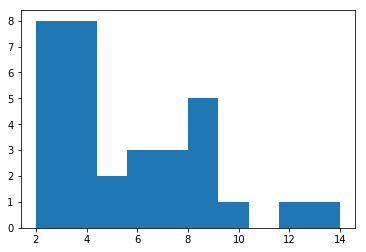

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
print([s for s in dir(nx) if s.endswith('graph')])
G = nx.davis_southern_women_graph()
plt.hist(list(nx.degree(G).values()))
plt.show()

/usr/local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/local/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


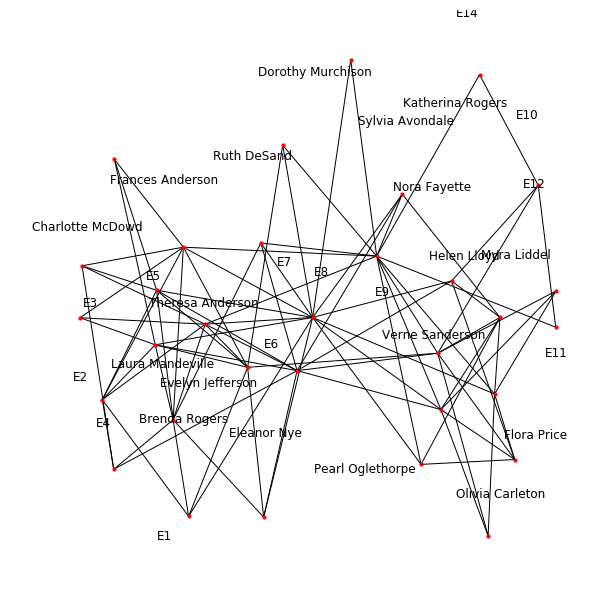

In [16]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G)
nx.draw(G, node_size=10)
nx.draw_networkx_labels(G, pos)
plt.show()

In [17]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, node_size=2)
nx.draw(G)
nx.draw_networkx_labels(G, pos)
plt.show()

TypeError: fruchterman_reingold_layout() got an unexpected keyword argument 'node_size'